# Twitter Sentiment Analysis with BERT

Perform Text Classification on the data. The tweets have been pulled from `Twitter` and manual tagging has been done then.
The names and usernames have been given codes to avoid any privacy concerns.

<b>Columns:</b>
1) Location<br>
2) Tweet At<br>
3) Original Tweet<br>
4) Label

The purpose of this project is to perform a Sentiment Analysis on tweets concerning coronavirus in order to predict the sentiment of a tweet using `BERT` and `roBERTa` algorithms (Positive, Negative or Neutral). BERT and ROBERTA, in particular, will be fine-tuned using the provided dataset to improve the model's overall performance.

The tweets will be thoroughly cleaned before being fed to the algorithms, removing links, hashtags at the end of sentences, and punctuation to help better grasp the language and enhance prediction performance.

In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

import warnings
warnings.filterwarnings("ignore")

<Figure size 432x288 with 0 Axes>

In [2]:
data = pd.read_csv("./datas/Corona_NLP_train.csv", encoding="ISO-8859-1")
test_data = pd.read_csv("./datas/Corona_NLP_test.csv", encoding="ISO-8859-1")

In [3]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
# converting to datetime
data['TweetAt'] = pd.to_datetime(data['TweetAt'])

In [6]:
data['TweetAt'].dtype

dtype('<M8[ns]')

In [7]:
# checking the duplicate tweets
data.drop_duplicates(subset="OriginalTweet", inplace=True)

In [8]:
data['Location'].unique()

array(['London', 'UK', 'Vagabonds', ..., 'Juba south sudan', 'OHIO',
       'i love you so much || he/him'], dtype=object)

In [9]:
data['Location'].value_counts()

London                          540
United States                   528
London, England                 520
New York, NY                    395
Washington, DC                  373
                               ... 
Staffordshire Moorlands           1
Kithchener ON                     1
Tulsa, Ok                         1
Watford, South Oxhey, Bushey      1
i love you so much || he/him      1
Name: Location, Length: 12220, dtype: int64

In [10]:
tweets_countries = data['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='number')
tweets_countries

,index,number
0,London,540
1,United States,528
2,"London, England",520
3,"New York, NY",395
4,"Washington, DC",373
5,United Kingdom,337
6,"Los Angeles, CA",281
7,India,268
8,UK,232
9,Australia,225


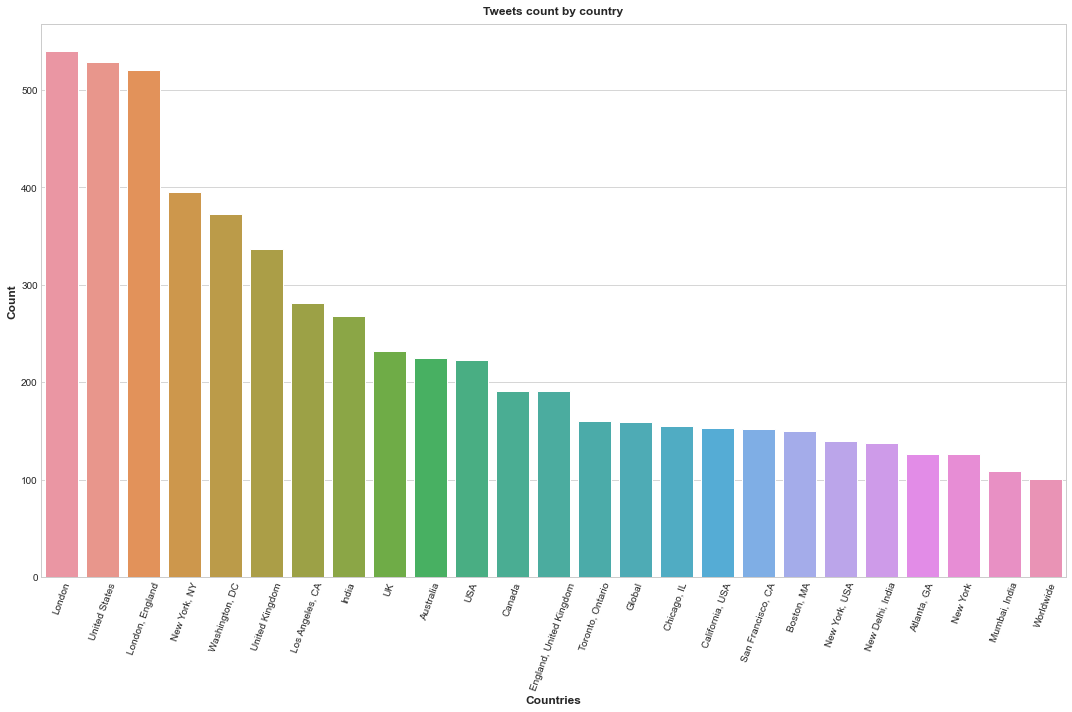

In [11]:
plt.figure(figsize = (15,10))
sns.barplot(x='index', y='number', data= tweets_countries, ci=False)
plt.title('Tweets count by country')
plt.xlabel("Countries")
plt.ylabel("Count")
plt.xticks(rotation=70);

## Cleaning Tweets

In [12]:
df = data[['OriginalTweet','Sentiment']]
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [13]:
df_test = test_data[['OriginalTweet','Sentiment']]
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [14]:
def remove_emoji(text):
    
    text = re.sub(emoji.get_emoji_regexp(),r"",text)
    return text

#### The r prefix is part of the string syntax. With r, Python doesn't interpret backslash sequences such as \n, \t etc inside the quotes. Without r, you'd have to type each backslash twice in order to pass it to re.sub.


In [15]:
def remove_punctuation(text):
    
    text = text.replace('\r','').replace('\n',' ').replace('\n',' ').lower() # remove punctuations
    text = re.sub(r"(?:\@|https?\://)\S+","",text) # remove links
    text = re.sub(r"[^\x00-\x7f]",r"",text) # remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    
    return text

In [16]:
def remove_special_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

In [17]:
def remove_hastags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text)) #remove hashtags symbol from words in the middle of the sentence
    
    return new_text2

In [18]:
def remove_multiple_spaces(text):
    
    text = re.sub("\s\s+", " ", text)
    return text

In [19]:
cleaned_tweets = []
for t in df.OriginalTweet:
    cleaned_tweets.append(remove_multiple_spaces(remove_special_chars(remove_hastags(remove_punctuation(remove_emoji(t))))))

In [20]:
print(data['OriginalTweet'][0])
print("\n")
print(cleaned_tweets[0])

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8


and and


In [21]:
cleaned_test_tweets = []
for t in df_test.OriginalTweet:
    cleaned_test_tweets.append(remove_multiple_spaces(remove_punctuation(remove_emoji(t))))

In [22]:
print(df_test['OriginalTweet'][0])
print("\n")
print(cleaned_test_tweets[0])

TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1


trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as coronavirusfearing shoppers stock up 


In [23]:
df['cleaned_tweet'] = cleaned_tweets
df_test['cleaned_tweet'] = cleaned_test_tweets

In [24]:
df.head()

,OriginalTweet,Sentiment,cleaned_tweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...


In [25]:
text_length = []

for text in df['cleaned_tweet']:
    text_len = len(text.split())
    text_length.append(text_len)
    
text_length[:10]

[2, 38, 13, 41, 39, 34, 27, 12, 44, 42]

In [26]:
df['text_length'] = text_length

df.head()

,OriginalTweet,Sentiment,cleaned_tweet,text_length
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,and and,2
1,advice Talk to your neighbours family to excha...,Positive,advice talk to your neighbours family to excha...,38
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths to give elder...,13
3,My food stock is not the only one which is emp...,Positive,my food stock is not the only one which is emp...,41
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,me ready to go at supermarket during the covid...,39


In [27]:
test_text_length = []

for text in df_test['cleaned_tweet']:
    text_len = len(text.split())
    test_text_length.append(text_len)
    
test_text_length[:10]

[21, 29, 12, 35, 25, 33, 9, 27, 52, 35]

In [28]:
df_test['text_length'] = test_text_length

df_test.head()

,OriginalTweet,Sentiment,cleaned_tweet,text_length
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...,21
1,When I couldn't find hand sanitizer at Fred Me...,Positive,when i couldnt find hand sanitizer at fred mey...,29
2,Find out how you can protect yourself and love...,Extremely Positive,find out how you can protect yourself and love...,12
3,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city as anxious shop...,35
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...,25


In [29]:
print("Train dataframe shape: ",df.shape)
print("Test dataframe shape: ",df_test.shape)

Train dataframe shape:  (41157, 4)
Test dataframe shape:  (3798, 4)


### Training data cleaning

In [30]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

The `max_length` specifies the length of the tokenized text. By default, **BERT** performs word-piece tokenization. For example the word "*playing*" can be split into "*play*" and "*##ing*" (This may not be very precise, but just to help you understand about word-piece tokenization), followed by adding [CLS] token at the beginning of the sentence, and [SEP] token at the end of sentence. Thus, it first tokenizes the sentence, truncates it to max_length-2 (if truncation=True), then prepend [CLS] at the beginning and [SEP] token at the end.(So a total length of max_length)

In [31]:
token_list = []

for text in df['cleaned_tweet'].values:
    tokens = tokenizer.encode(text,max_length=512, truncation=True)
    token_list.append(len(tokens))
    
max_length = max(token_list)
print("Maximum length of a token : ", max_length)

Maximum length of a token :  100


In [32]:
for index,value in enumerate(df['cleaned_tweet'].values):
    tokens = tokenizer.encode(value,max_length=512, truncation=True)
    if len(tokens) > 80:
        print(f"Maximum token at index {index} is : {value}.\n")

Maximum token at index 1638 is : zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme.

Maximum token at index 13691 is : hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan.

Maximum token at index 16632 is : bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar.

Maximum token at index 37156 is : 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 

In [33]:
df["cleaned_tweet"][37156]

'11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededir halkmz sakin olsun ve gvende hissetsin ltfen herkes evine dnsn'

In [34]:
df["cleaned_tweet"][37213]

'amp 2gethertheseries 450 qr code 11 63 gmmtv'

In [35]:
df['token_length'] = token_list

In [36]:
df = df.sort_values(by="token_length", ascending=False)
df.head(15)

,OriginalTweet,Sentiment,cleaned_tweet,text_length,token_length
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79


In [37]:
df = df.iloc[13:]
df.head()

,OriginalTweet,Sentiment,cleaned_tweet,text_length,token_length
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76
9238,Hi @Zomato I felt hungry loggd in ur app tryd ...,Extremely Positive,hi i felt hungry loggd in ur app tryd to add 4...,55,75


In [38]:
df = df.sample(frac=1).reset_index(drop=True) # return all rows in random order
df.head()

,OriginalTweet,Sentiment,cleaned_tweet,text_length,token_length
0,So far @narendramodi Govt has been proactive i...,Extremely Negative,so far govt has been proactive in initiating s...,46,56
1,Was at the supermarket today. Didn't buy toile...,Neutral,was at the supermarket today didnt buy toilet ...,12,21
2,Supermarket in Denmark uses price trick to avo...,Extremely Negative,supermarket in denmark uses price trick to avo...,36,59
3,Economic Recovery From COVID-19 And Geopolitic...,Negative,economic recovery from covid19 and geopolitica...,38,47
4,NHS cardiac physiologist Gaetano Ferrante desc...,Negative,nhs cardiac physiologist gaetano ferrante desc...,23,31


In [39]:
token_test_length = []

for index,value in enumerate(df_test['cleaned_tweet'].values):
    tokens = tokenizer.encode(value, max_length=512, truncation=True)
    token_test_length.append(len(tokens))    
    
    if len(tokens) > 80:
        print(f"Maximum token at index {index} is : {value}.\n")

Maximum token at index 286 is :  so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b.

Maximum token at index 345 is : informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety.

Maximum token at index 2383 is : ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias .



In [40]:
df_test['token_length'] = token_test_length
df_test = df_test.sort_values(by="token_length", ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,cleaned_tweet,text_length,token_length
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl m...,38,96
2383,Ahora seguid llorando por el papel higiÃ©nico ...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zÃ¡stupce vÂech obchodnÃ­ch ?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-DonÂt Touch Face\r\r\nDWBH-Do Wash Both H...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,IÂm in the DC/Maryland/Virginia (DMV) area &a...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70


In [41]:
df_test = df_test.iloc[5:]
df_test.head()

,OriginalTweet,Sentiment,cleaned_tweet,text_length,token_length
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70


In [42]:
df_test = df_test.sample(frac=1).reset_index(drop=1)
df_test.head()

,OriginalTweet,Sentiment,cleaned_tweet,text_length,token_length
0,Calling ALL Caribbean s it s time we ask for s...,Negative,calling all caribbean s it s time we ask for s...,35,39
1,Seeing the empty shelves in the local grocery ...,Negative,seeing the empty shelves in the local grocery ...,40,44
2,DEMAND FOR ON-DEMAND DELIVERY Retailers servin...,Extremely Negative,demand for ondemand delivery retailers serving...,32,49
3,? | Supermarket queue in Italy due to the #cor...,Neutral,supermarket queue in italy due to the coronav...,39,44
4,Free online delivery code for orders over Â15...,Extremely Positive,free online delivery code for orders over 15 w...,30,39


In [43]:
df['Sentiment'].value_counts()

Positive              11421
Negative               9915
Neutral                7706
Extremely Positive     6624
Extremely Negative     5478
Name: Sentiment, dtype: int64

In [44]:
df['Sentiment'] = df['Sentiment'].map({'Positive':2,'Extremely Positive':2,
                                       'Negative':0,'Extremely Negative':0,
                                      'Neutral':1})

df_test['Sentiment'] = df_test['Sentiment'].map({'Positive':2,'Extremely Positive':2,
                                       'Negative':0,'Extremely Negative':0,
                                      'Neutral':1})

In [45]:
df['Sentiment'].value_counts() # classes are imbalanced

2    18045
0    15393
1     7706
Name: Sentiment, dtype: int64

In [46]:
ros = RandomOverSampler()

In [47]:
train_x, test_y = ros.fit_resample(np.array(df['cleaned_tweet']).reshape(-1,1),
                                   np.array(df['Sentiment']).reshape(-1,1))

In [48]:
train_x

array([['so far govt has been proactive in initiating steps to deal with coronavirus but govt capacities are limited it will come down to us as a people will we follow advisories on social distancing amp self quarantine if citizens violate theres little the govt can do'],
       ['was at the supermarket today didnt buy toilet paper rebel toiletpapercrisis covid19'],
       ['supermarket in denmark uses price trick to avoid selfish buying 1 bottle 40 kr rm1693 if 2 bottles 100 kr rm4233 malaysia should apply this instead of selling for kelik mekoh balik hari covid19 covid19malaysia handsanitizer'],
       ...,
       ['today i saw a man wearing a medical mask ski goggles and gardening gloves on at the grocery store and it barely registers newnormal coronavirus'],
       ['oil prices at 2318 oilprices coronavirus'],
       ['me when i cough at the grocery store coronavirus quarantinelife']],
      dtype=object)

In [49]:
test_y = list(test_y)

x_train=[]
for x in train_x:
    x_train.append(x[0])

In [50]:
train_data = pd.DataFrame({'Sentiment':test_y,'CleanedTweet':x_train})
train_data.head()

,Sentiment,CleanedTweet
0,0,so far govt has been proactive in initiating s...
1,1,was at the supermarket today didnt buy toilet ...
2,0,supermarket in denmark uses price trick to avo...
3,0,economic recovery from covid19 and geopolitica...
4,0,nhs cardiac physiologist gaetano ferrante desc...


In [51]:
train_data['Sentiment'].value_counts()

0    18045
1    18045
2    18045
Name: Sentiment, dtype: int64

In [52]:
X = train_data['CleanedTweet'].values
y = train_data['Sentiment'].values

**stratify** : the `train_test_split` method returns training and test subsets that have the same proportions of class labels as the input dataset.

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y,random_state=seed)

In [54]:
X_test = df_test['cleaned_tweet'].values
y_test = df_test['Sentiment'].values

In [55]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [56]:
# One Hot Encoding
one_hot_encoder = preprocessing.OneHotEncoder()

In [57]:
y_train = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = one_hot_encoder.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [58]:
X_train.shape[0]

48721

In [59]:
print("Training data:", X_train.shape)
print("Validation data:", X_valid.shape)
print("Test data:", X_test.shape)

Training data: (48721,)
Validation data: (5414,)
Test data: (3793,)


In [60]:
clf = CountVectorizer()
X_train_token = clf.fit_transform(X_train)
X_test_token = clf.transform(X_test)

Do not call `fit_transform()` on the test data as the transformers will learn a new vocabulary and not transform the test data the same way the training data was transformed. To use the same vocabulary as for the training data, use only `transform()` on the test data.

In [61]:
# TF-IDF (term-frequency times inverse document-frequency)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_token)
X_train_transformer = tf_transformer.transform(X_train_token)
X_test_transformer = tf_transformer.transform(X_test_token)

In [62]:
# Naive Bayes Classifier

nbc = MultinomialNB()

nbc.fit(X_train_transformer,y_train_le)

MultinomialNB()